In [1]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

from utils.multiprocessing_env import SubprocVecEnv
from utils.minipacman import MiniPacman
from utils.environment_model import *
from utils.actor_critic import ActorCritic, RolloutStorage
from utils.imagination_augmented_agent import RolloutEncoder, ImaginationCore, I2A

from IPython import display
from IPython.core.debugger import set_trace
from joblib import Parallel, delayed


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
mode = "regular"
env = MiniPacman(mode, 1000)
batch_size = 1
num_actions = env.action_space.n
state_shape = env.observation_space.shape

# Loading trained models

In [3]:
env_path = os.path.join("training", "environment_model", "env_model")
env_checkpoint = torch.load(env_path, map_location=DEVICE)

env_model = EnvModel(state_shape, num_actions, num_pixels, len(mode_rewards[mode]))
env_model.load_state_dict(env_checkpoint)
env_model.to(DEVICE)

print("loading env_model successfully")

loading env_model successfully


In [4]:
a2c_path = os.path.join("training", "actor_critic", "actor_critic_checkpoint")
a2c_checkpoint = torch.load(a2c_path, map_location=DEVICE)

a2c = ActorCritic(state_shape, num_actions)
a2c.load_state_dict(a2c_checkpoint['actor_critic_state_dict'])
a2c.to(DEVICE)
a2c_all_rewards = a2c_checkpoint['all_rewards']

print("loading a2c successfully")

loading a2c successfully


In [5]:
i2a_r1_path = os.path.join("training", "imagination_augmented_agents_rollout_1", "I2A_checkpoint")
i2a_r1_checkpoint = torch.load(i2a_r1_path, map_location=DEVICE)

i2a_r1_imagination = i2a_r1_checkpoint['imagination']

i2a_r1 = I2A(state_shape, num_actions, len(mode_rewards[mode]), 256, i2a_r1_imagination, full_rollout=True)
i2a_r1.load_state_dict(i2a_r1_checkpoint['actor_critic_state_dict'])
i2a_r1.to(DEVICE)
i2a_r1_all_rewards = i2a_r1_checkpoint['all_rewards']

print("loading i2a_r1 successfully")

loading i2a_r1 successfully


In [6]:
i2a_r5_path = os.path.join("training", "imagination_augmented_agents_rollout_5", "I2A_checkpoint")
i2a_r5_checkpoint = torch.load(i2a_r5_path, map_location=DEVICE)

i2a_r5_imagination = i2a_r5_checkpoint['imagination']

i2a_r5 = I2A(state_shape, num_actions, len(mode_rewards[mode]), 256, i2a_r5_imagination, full_rollout=True)
i2a_r5.load_state_dict(i2a_r5_checkpoint['actor_critic_state_dict'])
i2a_r5.to(DEVICE)
i2a_r5_all_rewards = i2a_r5_checkpoint['all_rewards']

print("loading i2a_r5 successfully")

loading i2a_r5 successfully


In [7]:
dqn100_path = os.path.join("training", "dqn_freq_100", "dqn_checkpoint")
dqn100_checkpoint = torch.load(dqn100_path, map_location=DEVICE)
dqn100_all_rewards = dqn100_checkpoint['all_rewards']

dqn1000_path = os.path.join("training", "dqn_freq_1000", "dqn_checkpoint")
dqn1000_checkpoint = torch.load(dqn1000_path, map_location=DEVICE)
dqn1000_all_rewards = dqn1000_checkpoint['all_rewards']

dqn10000_path = os.path.join("training", "dqn_freq_10000", "dqn_checkpoint")
dqn10000_checkpoint = torch.load(dqn10000_path, map_location=DEVICE)
dqn10000_all_rewards = dqn10000_checkpoint['all_rewards']

# Training results

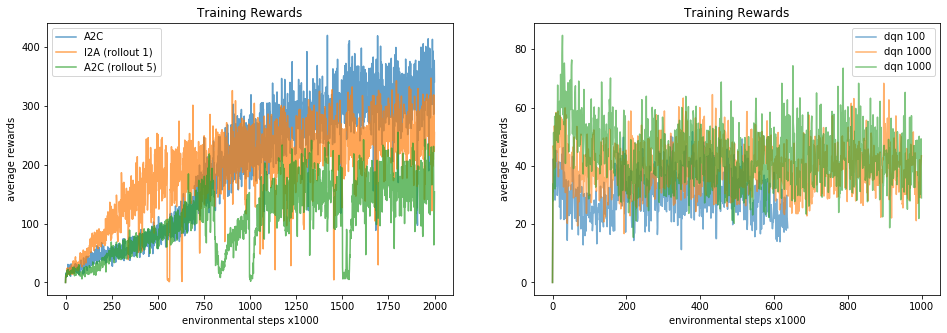

In [8]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.title("Training Rewards")
plt.plot(a2c_all_rewards[:2000], alpha=0.7, label="A2C")
plt.plot(i2a_r1_all_rewards[:2000], alpha=0.7, label="I2A (rollout 1)")
plt.plot(i2a_r5_all_rewards[:2000], alpha=0.7, label="A2C (rollout 5)")
plt.xlabel("environmental steps x1000")
plt.ylabel("average rewards")
plt.legend()

plt.subplot(122)
plt.title("Training Rewards")
plt.plot(dqn100_all_rewards[:1000], alpha=0.6, label="dqn 100")
plt.plot(dqn1000_all_rewards[:1000], alpha=0.6, label="dqn 1000")
plt.plot(dqn10000_all_rewards[:1000], alpha=0.6, label="dqn 1000")
plt.xlabel("environmental steps x1000")
plt.ylabel("average rewards")
plt.legend()

fig = plt.gcf()
fig.savefig(os.path.join("results", "training_rewards.pdf"), bbox_inches="tight")
plt.show()

# Testing results

In [9]:
num_games = 200

In [10]:
def test_agent(test_agent, env, max_steps=1000):
    state = env.reset()
    done = False
    test_rewards = []
    total_reward = 0

    while not done and len(test_rewards) < max_steps:
        current_state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        action = test_agent.act(current_state)
        next_state, reward, done, _ = env.step(action.data[0, 0])
        total_reward += reward
        state = next_state
        
        test_rewards.append(total_reward)
        
    if len(test_rewards) < max_steps:
        test_rewards += [total_reward] * (max_steps - len(test_rewards))
        
    test_rewards = np.array(test_rewards)
    return test_rewards

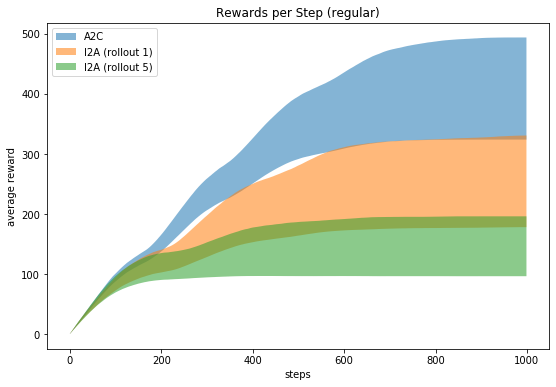

In [11]:
mode = "regular"
env = MiniPacman(mode, 1000)

i2a_r5_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(i2a_r5, env) for i in range(num_games))
i2a_r5_all_test_rewards = np.array(i2a_r5_all_test_rewards)

i2a_r1_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(i2a_r1, env) for i in range(num_games))
i2a_r1_all_test_rewards = np.array(i2a_r1_all_test_rewards)

a2c_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(a2c, env) for i in range(num_games))
a2c_all_test_rewards = np.array(a2c_all_test_rewards)

all_test_rewards = [a2c_all_test_rewards, i2a_r1_all_test_rewards, i2a_r5_all_test_rewards]
model_names = ["A2C", "I2A (rollout 1)", "I2A (rollout 5)"]

plt.figure(figsize=(9, 6))

for rewards, name in zip(all_test_rewards, model_names):
    y = rewards.mean(0)
    y_err = rewards.std(0)
    plt.fill_between(np.arange(y.shape[0]), y-0.6*y_err, y+0.6*y_err, alpha=0.55, label=name)

    
plt.title(f"Rewards per Step ({mode})")
plt.xlabel("steps")
plt.ylabel("average reward")
plt.legend(loc="upper left")
fig = plt.gcf()
fig.savefig(os.path.join("results", "regular_rewards_per_step.pdf"), bbox_inches="tight")
plt.show()

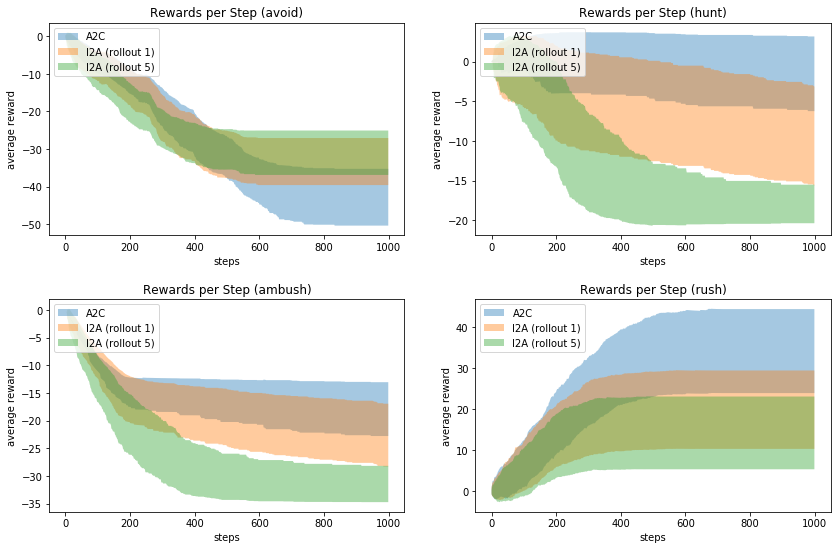

In [12]:
modes = ["avoid", "hunt", "ambush", "rush"]
plt.figure(figsize=(14, 9))


for i, mode in enumerate(modes):
    env = MiniPacman(mode, 1000)

    a2c_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(a2c, env) for i in range(num_games))
    a2c_all_test_rewards = np.array(a2c_all_test_rewards)

    i2a_r1_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(i2a_r1, env) for i in range(num_games))
    i2a_r1_all_test_rewards = np.array(i2a_r1_all_test_rewards)

    i2a_r5_all_test_rewards = Parallel(n_jobs=10)(delayed(test_agent)(i2a_r5, env) for i in range(num_games))
    i2a_r5_all_test_rewards = np.array(i2a_r5_all_test_rewards)
    
    all_test_rewards = [a2c_all_test_rewards, i2a_r1_all_test_rewards, i2a_r5_all_test_rewards]
    model_names = ["A2C", "I2A (rollout 1)", "I2A (rollout 5)"]
    
    plt.subplot(2, 2, i+1)
    for rewards, name in zip(all_test_rewards, model_names):
        y = rewards.mean(0)
        y_err = rewards.std(0)
        plt.fill_between(np.arange(y.shape[0]), y-0.6*y_err, y+0.6*y_err, alpha=0.4, label=name)
       
    plt.title(f"Rewards per Step ({mode})")
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend(loc="upper left")

plt.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.savefig(os.path.join("results", "all_mode_rewards_per_step.pdf"), bbox_inches="tight")
plt.show()